# 🏡Entendendo o Mercado Imobiliário de Fortaleza/CE
Com um Valor Geral de Vendas (VGV) de apróximadamente 8 bilhões de reais[*](https://cbic.org.br/recorde-historico-mercado-imobiliario-de-fortaleza-e-regiao-metropolitana-alcanca-valor-geral-de-vendas-de-r-85-bilhoes-em-2024/), a cidade de Fortaleza tem um mercado imobiliário forte e crescente. Com dados obtidos através do processo de *web scraping* nos sites da Imobiliária Lopes[**](lopes.com.br) e no site Chaves na Mão[***](chavesnamao.com.br) este projeto tem o objetivo de explorar o estado atual do mercado imobiliário.

# 🔎 Conhecendo os Dados
## Dicionário de Dados
|Coluna|Descrição|
|---|---|
|`id`|Identificador único de cada registro|
|`origem`|Site de onde os dados foram coletados|
|`tipo`|Tipo de imóvel|
|`localizacao`|Bairro de Fortaleza/CE|
|`ser`|Secretária Executiva Regional do bairro|
|`prox_centro`|Bairro localizado próximo ao Centro|
|`prox_orla`|Bairro próximo à orla maritima|
|`area`|Área em metros quadrados|
|`quartos`|Número de quartos|
|`banheiros`|Número de banheiros|
|`vagas`|Número de vagas de garagem|
|`condo`|Valor em R$ do condomínio|
|`preco`|Valor de anúncio em R$|
|`timestamp_extracao`|Timestamp da extração dos dados|

## Preparação do ambiente

In [114]:
# Manipulação de dados
import pandas as pd
import numpy as np
import duckdb
from sqlalchemy import create_engine

# Visualização de dados
import plotly.express as px

# Notebook config
import warnings
warnings.filterwarnings('ignore')
palette = ['#0a369d', '#4472ca', '#5e7ce2', '#92b4f4', '#cfdee7']
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [115]:
engine = create_engine('sqlite:///../data/imv_database.db')
df = pd.read_sql("SELECT * FROM raw_imoveis", engine)

## Qualidade dos dados

In [116]:
# Vou remover colunas que não serão utilizadas durante a análise
df = df.drop(columns = ['id', 'origem', 'timestamp_extracao'])

In [117]:
df.head()

,tipo,localizacao,ser,prox_centro,prox_orla,area,quartos,banheiros,vagas,condo,preco
0,Apartamento,Meireles,SER2,Sim,Sim,253,5,6,5,0.0,4194400.0
1,Apartamento,Mucuripe,SER2,Não,Sim,333,4,5,4,3000.0,3200000.0
2,Apartamento,Meireles,SER2,Sim,Sim,66,2,2,1,0.0,1990000.0
3,Apartamento,Engenheiro Luciano Cavalcante,SER7,Não,Não,44,1,1,1,577.0,450000.0
4,Apartamento,Passaré,SER8,Não,Não,63,3,2,2,436.0,420000.0


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531 entries, 0 to 5530
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tipo         5531 non-null   object 
 1   localizacao  5531 non-null   object 
 2   ser          5531 non-null   object 
 3   prox_centro  5531 non-null   object 
 4   prox_orla    5531 non-null   object 
 5   area         5531 non-null   int64  
 6   quartos      5531 non-null   int64  
 7   banheiros    5531 non-null   int64  
 8   vagas        5531 non-null   int64  
 9   condo        5531 non-null   float64
 10  preco        5531 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 475.4+ KB


In [119]:
print(f"O dataset tem {df.shape[0]} linhas, e {df.shape[1]} colunas.")

O dataset tem 5531 linhas, e 11 colunas.


In [120]:
print(f"O dataset possui {len(df.select_dtypes(include='number').columns)} colunas numéricas.")
print(f"O dataset possui {len(df.select_dtypes(exclude='number').columns)} colunas categóricas.")

O dataset possui 6 colunas numéricas.
O dataset possui 5 colunas categóricas.


In [121]:
print(f"O dataset possui {df.isnull().sum().sum()} dados nulos.")
print(f"O dataset possui {df.duplicated().sum()} dados duplicados.")

O dataset possui 0 dados nulos.
O dataset possui 141 dados duplicados.


In [122]:
# Remoção de dados duplicados
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [123]:
df.shape

(5390, 11)

In [124]:
df.nunique().sort_values()

prox_centro       2
prox_orla         2
tipo             12
ser              13
banheiros        15
quartos          16
vagas            22
localizacao     128
area            511
condo           822
preco          1122
dtype: int64

### Estatísticas descritivas

In [125]:
df.select_dtypes(include='number').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
area,5390.0,172.93,167.53,34.0,80.0,126.0,211.00,4035.0
quartos,5390.0,3.27,1.20,1.0,3.0,3.0,4.00,23.0
banheiros,5390.0,3.28,1.51,1.0,2.0,3.0,4.00,18.0
vagas,5390.0,2.70,4.29,0.0,2.0,2.0,3.00,283.0
condo,5390.0,1067.55,17975.51,0.0,0.0,370.0,930.00,898000.0
preco,5390.0,963984.55,1233575.63,80000.0,390000.0,623500.0,999461.25,20000000.0


Como esperado em um dataset que trata do mercado imobiliário, diversos outliers vão surgir especialmente no preço. Aqui podemos ver uma grande diferença nos terceiros quartis de todas as variáveis para o valor máximo, indicando outliers em todas as colunas numéricas. 

Mas algo que parece bem fora do normal são condomínios com valores tão altos como R$ 898.000,00 (não faz sentido). Além de um imóvel com 283 vagas de garagem. 

### Identificação de outliers

In [126]:
def outlier_check(df:pd.DataFrame, col:list):
    """
    Faz o check-up de outliers no DataFrame por coluna

    Parâmetros:
        df: pd.DataFrame - DataFrame com os dados
        col: list - Lista de colunas ou coluna isolada
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

In [127]:
for col in df.select_dtypes(include='number').columns.tolist():
    print(f"A coluna {col} tem {len(outlier_check(df, col))} outliers.")

A coluna area tem 328 outliers.
A coluna quartos tem 260 outliers.
A coluna banheiros tem 38 outliers.
A coluna vagas tem 592 outliers.
A coluna condo tem 217 outliers.
A coluna preco tem 504 outliers.


In [128]:
for col in df.select_dtypes(include='number').columns.tolist():
    print(f"A proporção de outliers na coluna {col} é de {len(outlier_check(df, col))/df.shape[0]:.2f}")

A proporção de outliers na coluna area é de 0.06
A proporção de outliers na coluna quartos é de 0.05
A proporção de outliers na coluna banheiros é de 0.01
A proporção de outliers na coluna vagas é de 0.11
A proporção de outliers na coluna condo é de 0.04
A proporção de outliers na coluna preco é de 0.09


In [129]:
def plot_box(df:pd.DataFrame, x:str, title:str, xaxis_title:str):
    """
    Faz o plot de um boxplot

    Parâmetros:
        df: pd.DataFrame - DataFrame com os dados
        x: str - Coluna que será plotada
        title: str - Título do gráfico
        xaxis_title: str - Título do eixo x
    """
    fig = px.box(
        df, 
        x = x,
        color_discrete_sequence=palette 
    )
    fig.update_layout(
        title = title,
        xaxis_title = xaxis_title,
        title_font={'size': 22},
        width=1200,
        height=600
    )

    return fig.show(renderer='png')

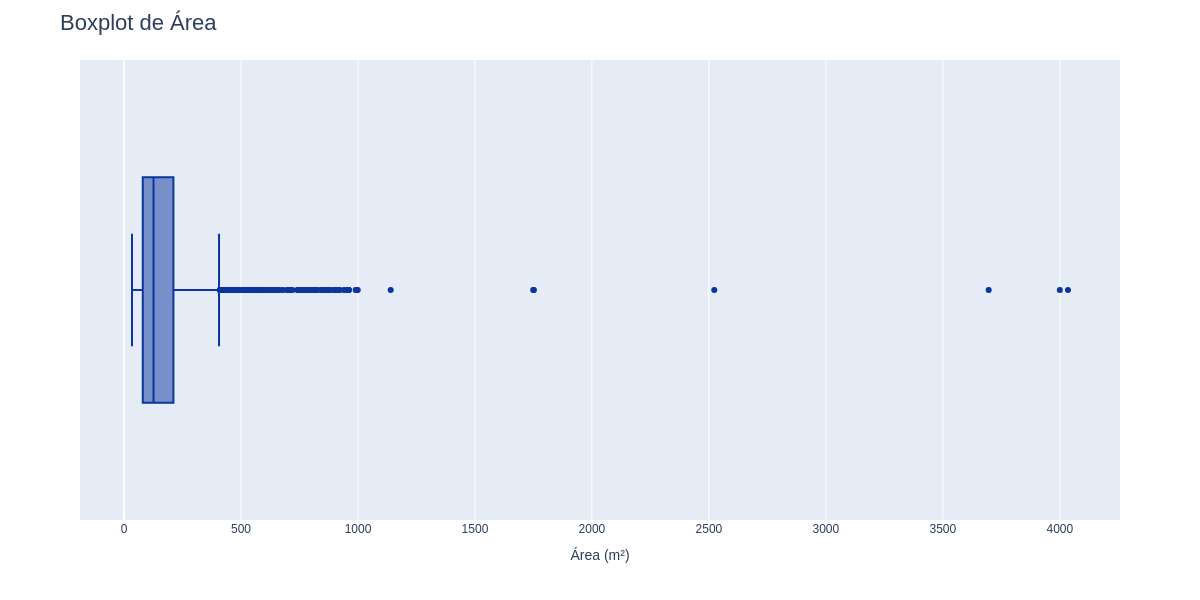

In [130]:
plot_box(df, 'area', 'Boxplot de Área', 'Área (m²)')

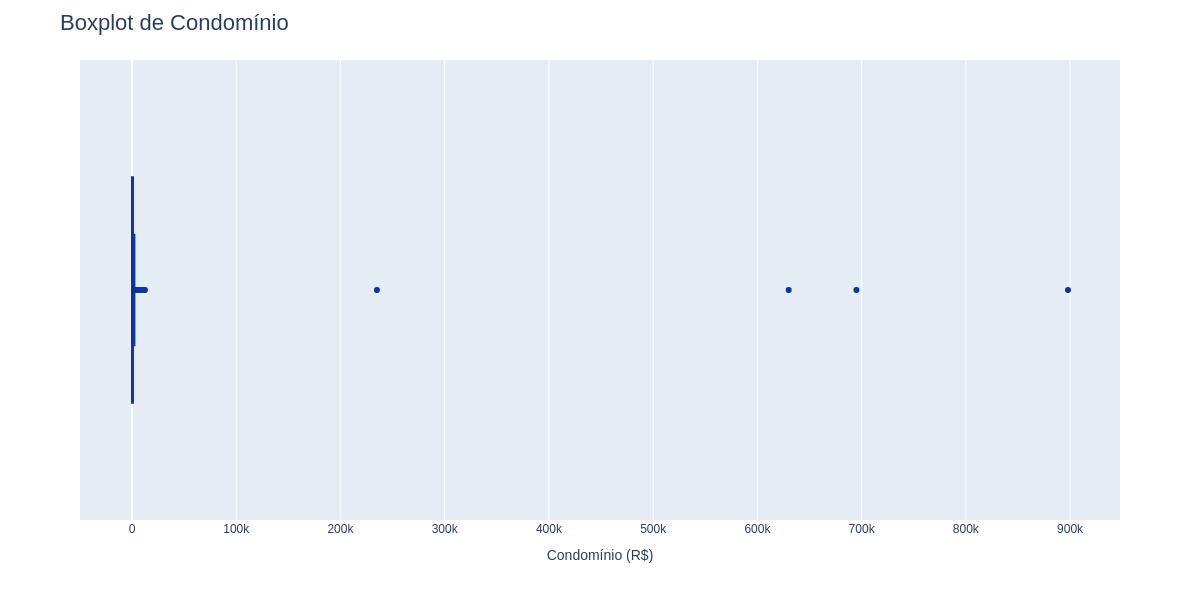

In [131]:
plot_box(df, 'condo', 'Boxplot de Condomínio', 'Condomínio (R$)')

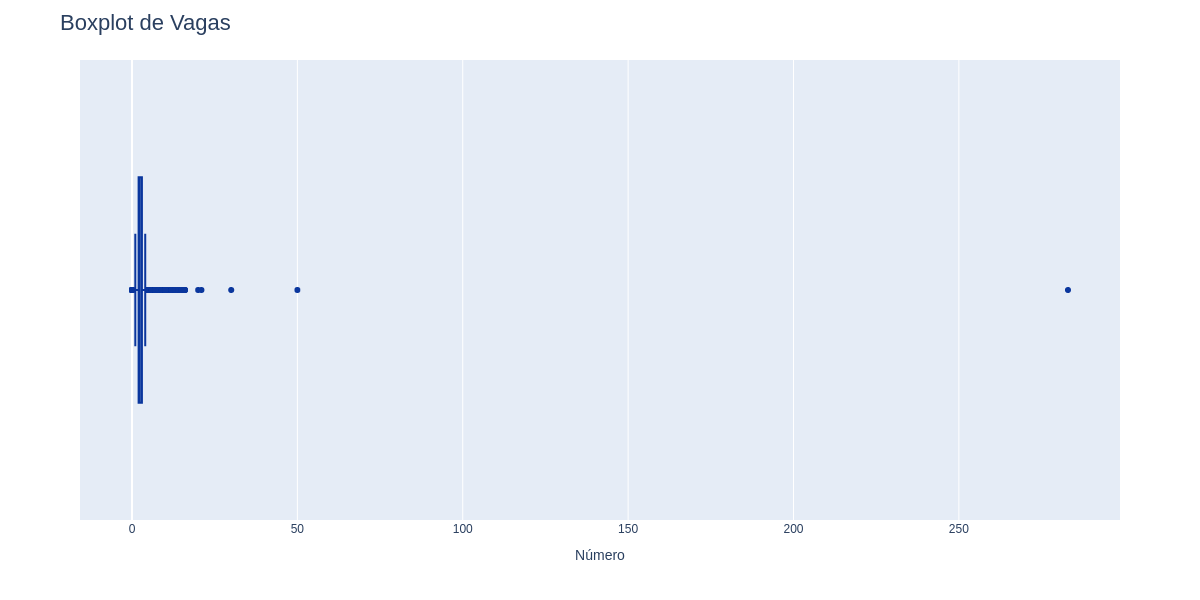

In [132]:
plot_box(df, 'vagas', 'Boxplot de Vagas', 'Número')

In [133]:
duckdb.sql("SELECT * FROM df WHERE vagas > 15")

┌─────────────┬───────────────────────────────┬─────────┬─────────────┬───────────┬───────┬─────────┬───────────┬───────┬────────┬───────────┐
│    tipo     │          localizacao          │   ser   │ prox_centro │ prox_orla │ area  │ quartos │ banheiros │ vagas │ condo  │   preco   │
│   varchar   │            varchar            │ varchar │   varchar   │  varchar  │ int64 │  int64  │   int64   │ int64 │ double │  double   │
├─────────────┼───────────────────────────────┼─────────┼─────────────┼───────────┼───────┼─────────┼───────────┼───────┼────────┼───────────┤
│ Apartamento │ Planalto Ayrton Senna         │ SER8    │ Não         │ Não       │    38 │       2 │         1 │   283 │    0.0 │  204000.0 │
│ Apartamento │ Meireles                      │ SER2    │ Sim         │ Sim       │   220 │       3 │         4 │    21 │ 2400.0 │ 4500000.0 │
│ Casa        │ Itaperi                       │ SER8    │ Não         │ Não       │   864 │       6 │         7 │    16 │  305.0 │  980000.0 │

In [134]:
duckdb.sql("SELECT * FROM df WHERE condo > 200000")

┌─────────────┬──────────────────────┬─────────┬─────────────┬───────────┬───────┬─────────┬───────────┬───────┬──────────┬──────────┐
│    tipo     │     localizacao      │   ser   │ prox_centro │ prox_orla │ area  │ quartos │ banheiros │ vagas │  condo   │  preco   │
│   varchar   │       varchar        │ varchar │   varchar   │  varchar  │ int64 │  int64  │   int64   │ int64 │  double  │  double  │
├─────────────┼──────────────────────┼─────────┼─────────────┼───────────┼───────┼─────────┼───────────┼───────┼──────────┼──────────┤
│ Apartamento │ Parque Iracema       │ SER6    │ Não         │ Não       │    70 │       3 │         2 │     2 │ 630000.0 │ 640000.0 │
│ Apartamento │ Varjota              │ SER2    │ Não         │ Não       │   120 │       3 │         3 │     2 │ 898000.0 │ 690000.0 │
│ Apartamento │ Prefeito José Walter │ SER8    │ Não         │ Não       │    44 │       2 │         2 │     1 │ 235000.0 │ 325000.0 │
│ Casa        │ Edson Queiroz        │ SER7    │ Não   

In [135]:
duckdb.sql("SELECT * FROM df WHERE area > 1000")

┌────────────────┬───────────────────────────────┬─────────┬─────────────┬───────────┬───────┬─────────┬───────────┬───────┬────────┬───────────┐
│      tipo      │          localizacao          │   ser   │ prox_centro │ prox_orla │ area  │ quartos │ banheiros │ vagas │ condo  │   preco   │
│    varchar     │            varchar            │ varchar │   varchar   │  varchar  │ int64 │  int64  │   int64   │ int64 │ double │  double   │
├────────────────┼───────────────────────────────┼─────────┼─────────────┼───────────┼───────┼─────────┼───────────┼───────┼────────┼───────────┤
│ Condomínio     │ de Lourdes                    │ SER2    │ Não         │ Não       │  4000 │       4 │         6 │     4 │ 2300.0 │ 2990000.0 │
│ Condomínio     │ Edson Queiroz                 │ SER7    │ Não         │ Não       │  2523 │       3 │         4 │     2 │ 1300.0 │  497000.0 │
│ Casa           │ Engenheiro Luciano Cavalcante │ SER7    │ Não         │ Não       │  1749 │       3 │         6 │    10 │

In [136]:
# Vamos eliminar estes registros
df = duckdb.sql("SELECT * FROM df WHERE vagas < 15 AND condo < 200000 AND area < 1000").to_df()

Para facilitar a análise vou criar variáveis ordinais para estas colunas onde: 0 = 0, 1 = 1, 2 = 2, 3 =3, 4 = 4, 5 = 5+.

In [137]:
df = duckdb.sql(
    """
    SELECT
        *
        , CASE WHEN quartos >= 5 THEN 5 ELSE quartos END AS quartos_ord
        , CASE WHEN banheiros >= 5 THEN 5 ELSE banheiros END AS banheiros_ord
        , CASE WHEN vagas >= 5 THEN 5 ELSE vagas END AS vagas_ord
    FROM df
    """
).to_df()

## Análise Exploratória de Dados

### Funções de plots

In [138]:
def plot_hist(df:pd.DataFrame, x:str, title:str, xaxis_title:str, yaxis_title:str):
    """
    Faz o plot de um histograma

    Parâmetros:
        df: pd.DataFrame - DataFrame com os dados
        x: str - Coluna que será plotada
        title: str - Título do gráfico
        xaxis_title: str - Título do eixo x
        yaxis_title: str - Título do eixo y
    """
    fig = px.histogram(
        df,
        x = x,
        title=title,
        histnorm='percent',
        nbins=50,
        color_discrete_sequence=palette
    )

    fig.update_layout(
        title_font={'size': 22},
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        bargap=0.05,
        width=1200,
        height=600
    )

    return fig.show(renderer='png')

In [139]:
def plot_bar(df:pd.DataFrame, x:str, title:str, xaxis_title:str, yaxis_title:str):
    """
    Faz o plot de um gráfico de barras

    Parâmetros:
        df: pd.DataFrame - DataFrame com os dados
        x: str - Coluna que será plotada
        title: str - Título do gráfico
        xaxis_title: str - Título do eixo x
        yaxis_title: str - Título do eixo y
    """
    fig = px.histogram(
        df,
        x =x,
        title=title,
        histnorm='percent',
        color_discrete_sequence=palette
    )

    fig.update_layout(
        title_font={'size': 22},
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        bargap=0.05,
        width=1200,
        height=600
    )

    return fig.show(renderer='png')

In [140]:
def plot_bars(df:pd.DataFrame, x:str, y:str, title:str, xaxis_title:str, yaxis_title:str):
    """
    Plota um gráfico de barras com informações do eixo y
    
    Parâmetros:
        df: pd.DataFrame - DataFrame com os dados
        x:str - Coluna do eixo x
        y:str - Coluna do eixo y
        title:str - Título do gráfico
        xaxis_title:str - Título do eixo x
        yaxis_title:str - Título do eixo y
    """
    fig = px.bar(
        df,
        x=x,
        y=y,
        title=title,
        color_discrete_sequence=palette
    )
    fig.update_layout(
        title_font={'size': 22},
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        width=1200,
        height=600
    )
    
    return fig.show(renderer='png')

### Análises Univariadas

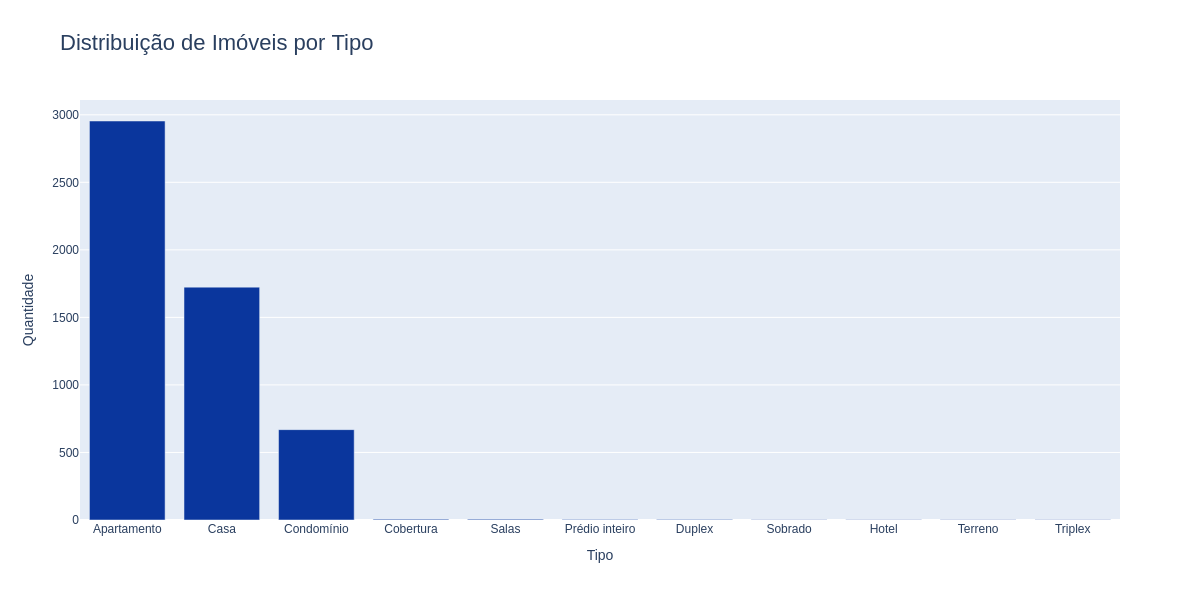

In [141]:
tipos = duckdb.sql("SELECT tipo, COUNT(tipo) AS count FROM df GROUP BY tipo ORDER BY 2 DESC")
plot_bars(tipos, 'tipo', 'count', 'Distribuição de Imóveis por Tipo', 'Tipo', 'Quantidade')

Existe uma quantidade irrelavante de imóveis de tipos diferentes de Apartamento, Casa e Condomínio, então vamos manter somente estes para o restante da análise. 

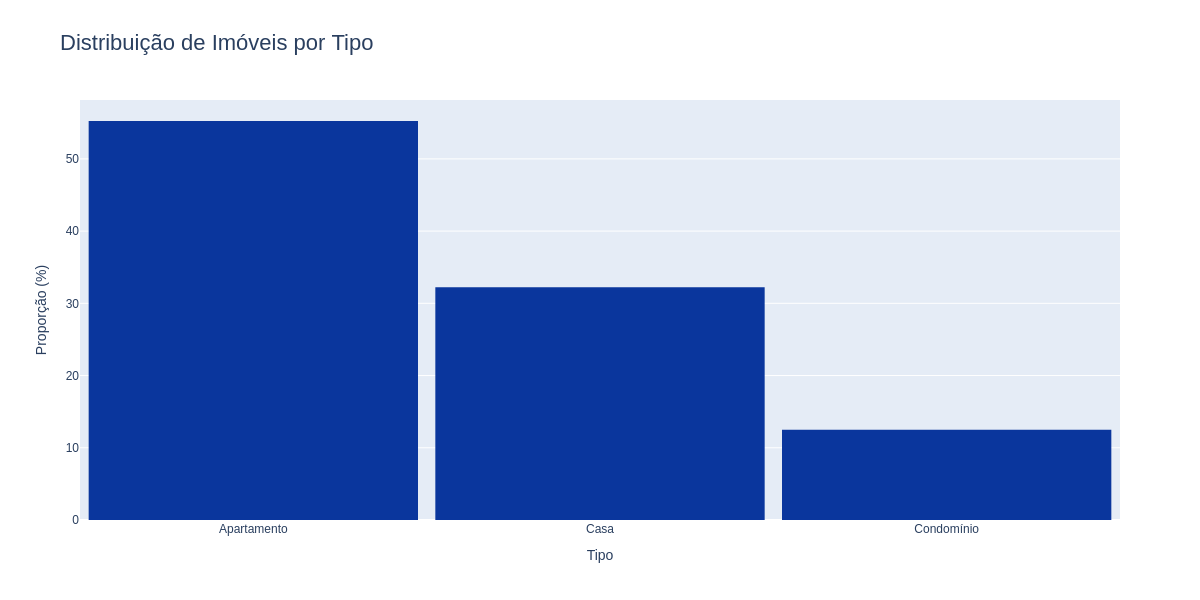

In [142]:
df = duckdb.sql("SELECT * FROM df WHERE tipo IN ('Apartamento', 'Casa', 'Condomínio')").to_df()
plot_bar(df, 'tipo', 'Distribuição de Imóveis por Tipo', 'Tipo', 'Proporção (%)')

Mais da metade dos imóveis em oferta são apartamentos, seguidos por casas e condomínios. O mercado imobiliário em grandes centros urbanos costuma se concentra na venda de apartamentos para uma parcela maior da população, e casas em condomínios para a clientes de classe média alta em diante, as razões de escolha por este tipo de imóvel costumam ser semelhantes:

- Infraestrutura compartilhada;
- Privacidade e segurança;
- Potencial de valorização.

Agora vamos partir para buscar os bairros com maior quantidade de imóveis em oferta. 

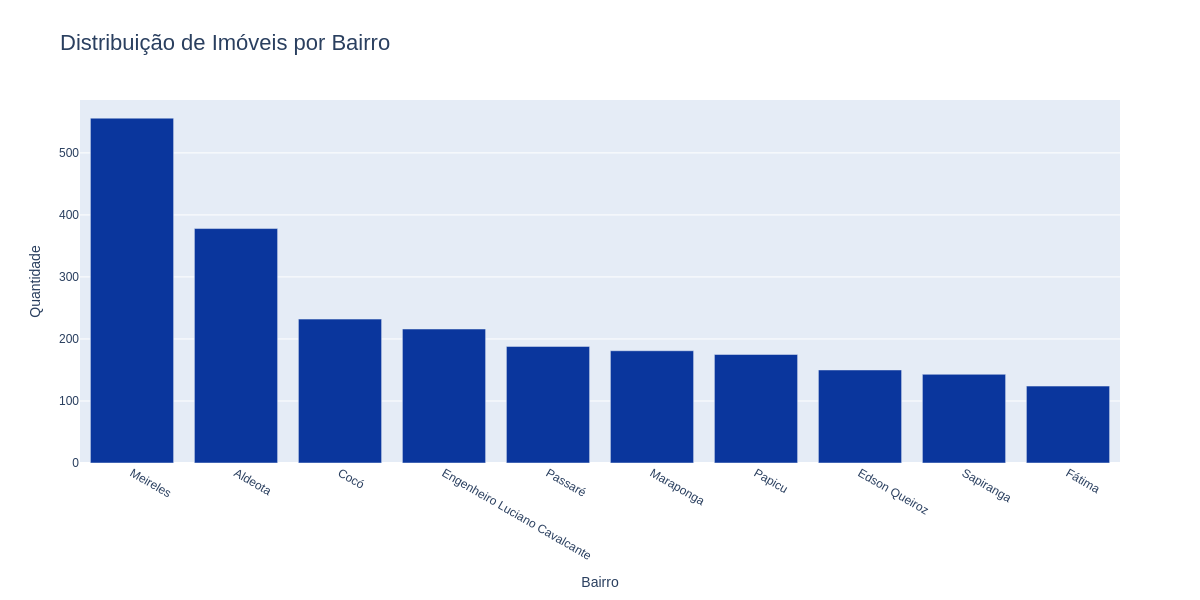

In [144]:
# Vamos reduzir para o top 10 para uma melhor visualização
bairros = duckdb.sql("SELECT localizacao, COUNT(localizacao) AS count FROM df GROUP BY localizacao ORDER BY 2 DESC LIMIT 10")
plot_bars(bairros, 'localizacao', 'count', 'Distribuição de Imóveis por Bairro', 'Bairro', 'Quantidade')

A oferta de imóveis se concentra em bairros da Secretária Executiva Regional (SER) 2 e 7. São áreas próximas ao centro e de bairros nobres da capital cearense, por tanto privilegiadas para o mercado imobiliário. Para contexto vou trazer o mapa da cidade com as SER[*](https://g1.globo.com/ce/ceara/noticia/2021/01/06/12-regionais-de-fortaleza-confira-a-nova-divisao-da-capital-cearense.ghtml). 

![JktxiIv - Imgur.png](<attachment:JktxiIv - Imgur.png>)
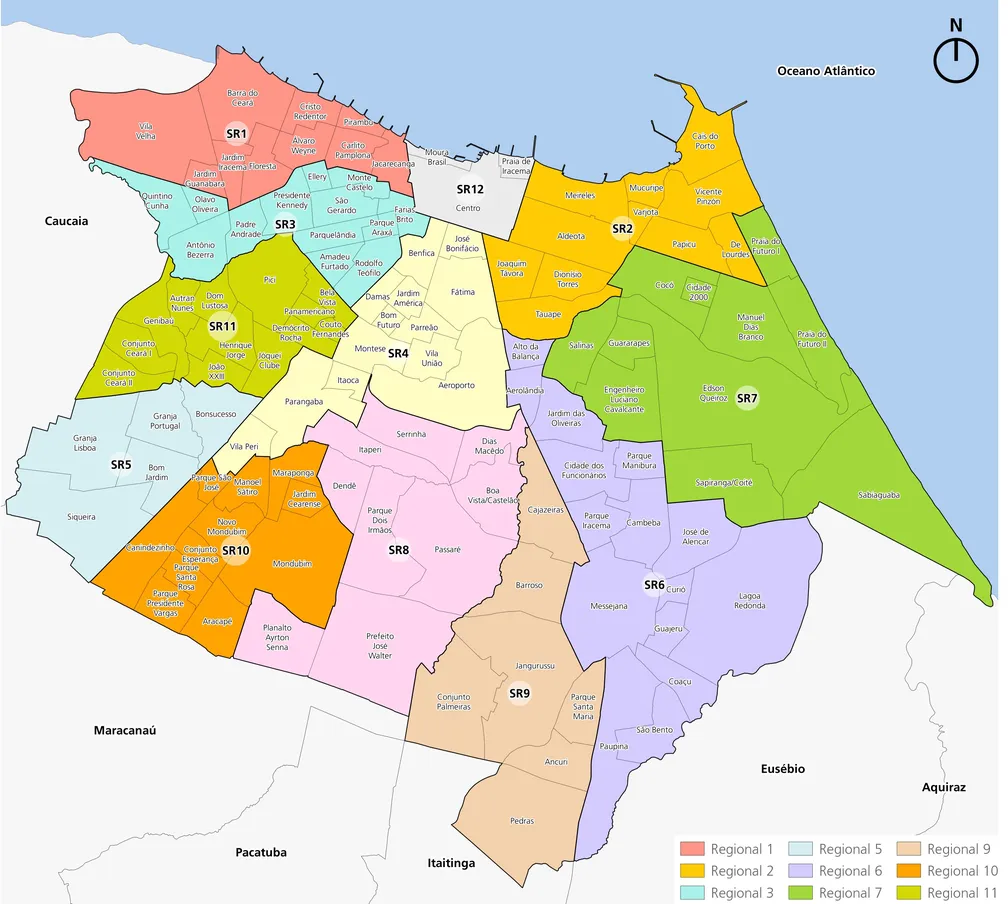

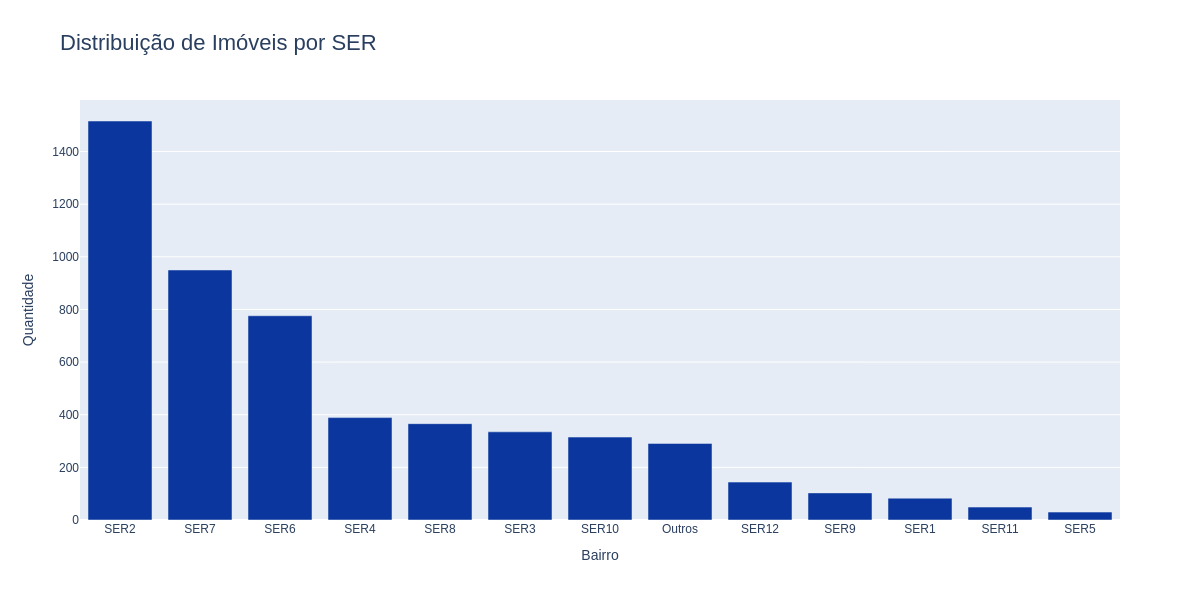

In [145]:
ser = duckdb.sql("SELECT ser, COUNT(ser) AS count FROM df GROUP BY ser ORDER BY 2 DESC")
plot_bars(ser, 'ser', 'count', 'Distribuição de Imóveis por SER', 'Bairro', 'Quantidade')

A oferta de imóveis se concentra nas SER 2, 6 e 7. 

- Na SER 2 estão bairros nobres e de alta valorização no mercado como Meireles, Mucuripe e Aldeota.
- Na SER 6 e 7 estão bairros de alta densidade populacional e bom nível de infraestrutura urbana, além de alguns deles serem relativamente próximos ao centro ou da orla marítima da cidade como Cocó, Cidade 200, Cidade dos Funcionários, Aerolândia, entre outros. 

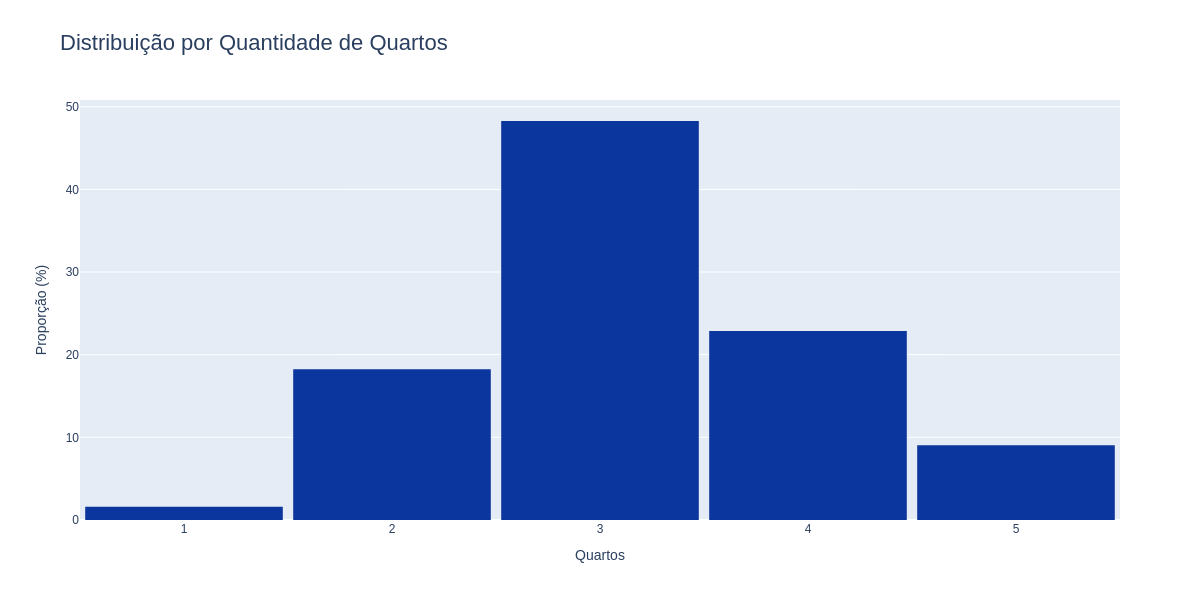

In [146]:
plot_bar(df, 'quartos_ord', 'Distribuição por Quantidade de Quartos', 'Quartos', 'Proporção (%)')

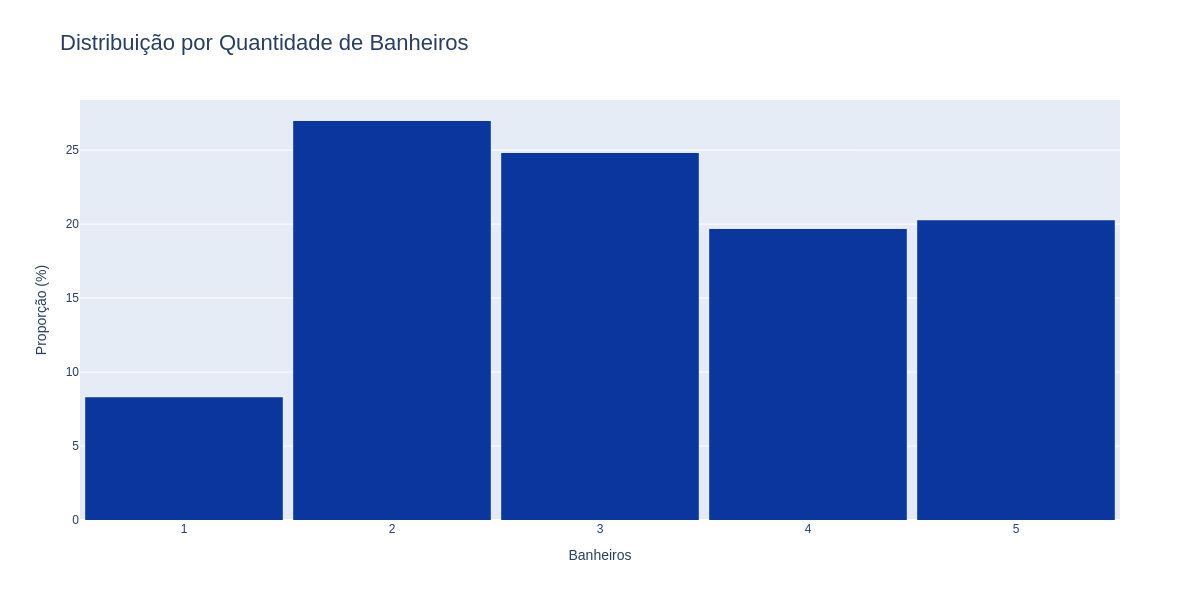

In [147]:
plot_bar(df, 'banheiros_ord', 'Distribuição por Quantidade de Banheiros', 'Banheiros', 'Proporção (%)')

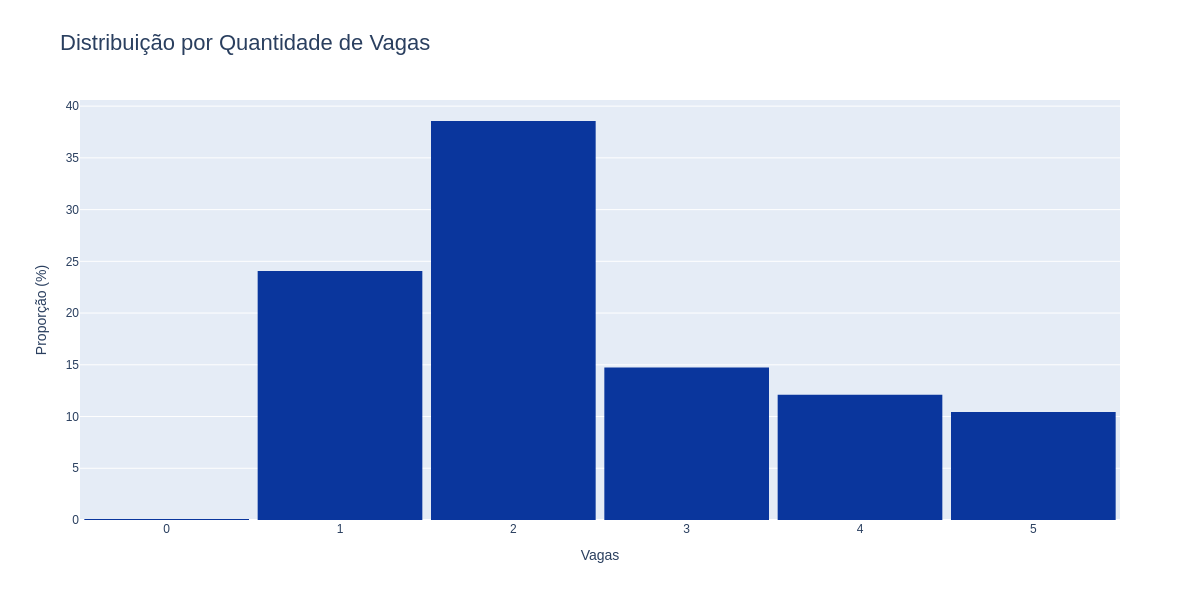

In [148]:
plot_bar(df, 'vagas_ord', 'Distribuição por Quantidade de Vagas', 'Vagas', 'Proporção (%)')

Existe um padrão na oferta de imóveis novos que é de apartamentos ou casas com 2 ou 3 quartos, e 2 ou 3 banheiros, sendo a estrutura mais comum 3 quartos e 2 banheiros. Em relação à vagas de garagem é importante sempre pensar na mobilidade urbana de uma cidade de grande população como Fortaleza, é muito comum a necessidade de um transporte particular então é natural que a oferta de imóveis com nenhuma vaga de garagem seja baixa. 

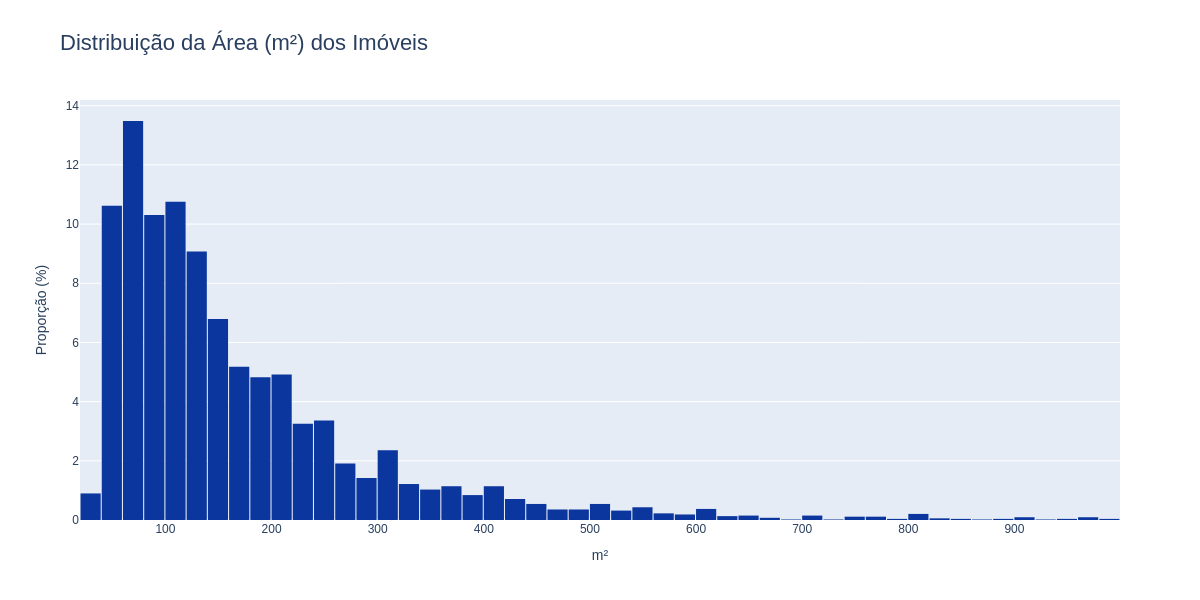

In [149]:
plot_hist(df, 'area', 'Distribuição da Área (m²) dos Imóveis', 'm²', 'Proporção (%)')

A oferta de imóveis se concentra naqueles com menos de 100m² de área total, possivelmente imóveis mais acessíveis financeiramente. 

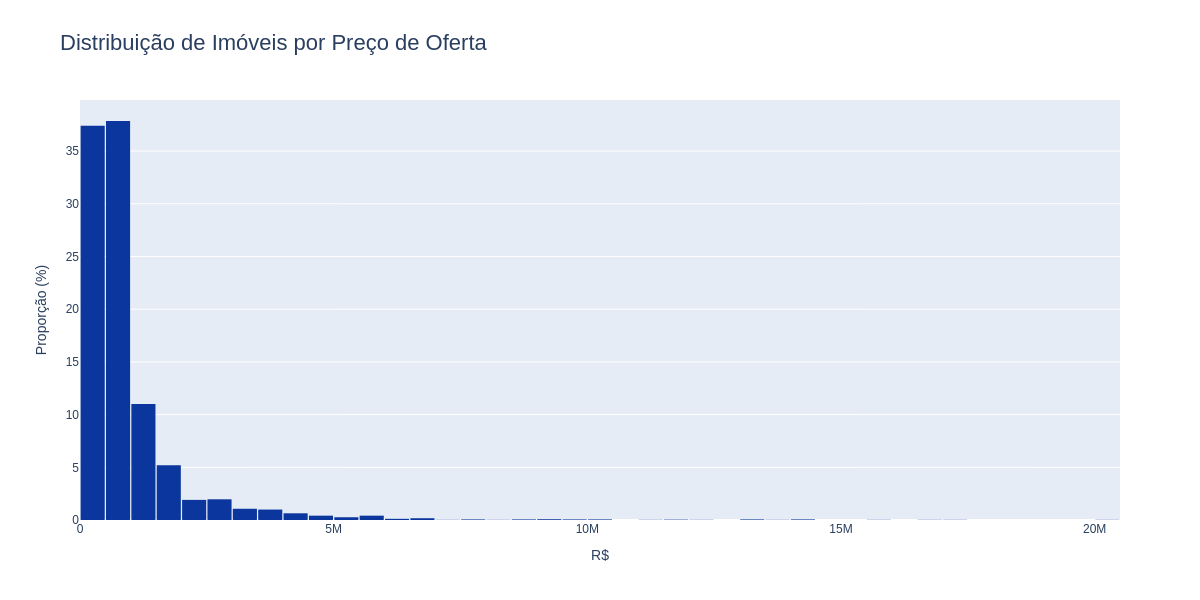

In [150]:
plot_hist(df, 'preco', 'Distribuição de Imóveis por Preço de Oferta', 'R$', 'Proporção (%)')

É natural valores cima do normal para dados tratando do mercado imobiliário, ofertas fora de valor ou imóveis com alto valor agregado são outliers naturais e esperados se tratando de dados sobre este ramo. Vamos visualizar os dados para imóveis até R$ 5.000.000,00 em seu valor de oferta. 

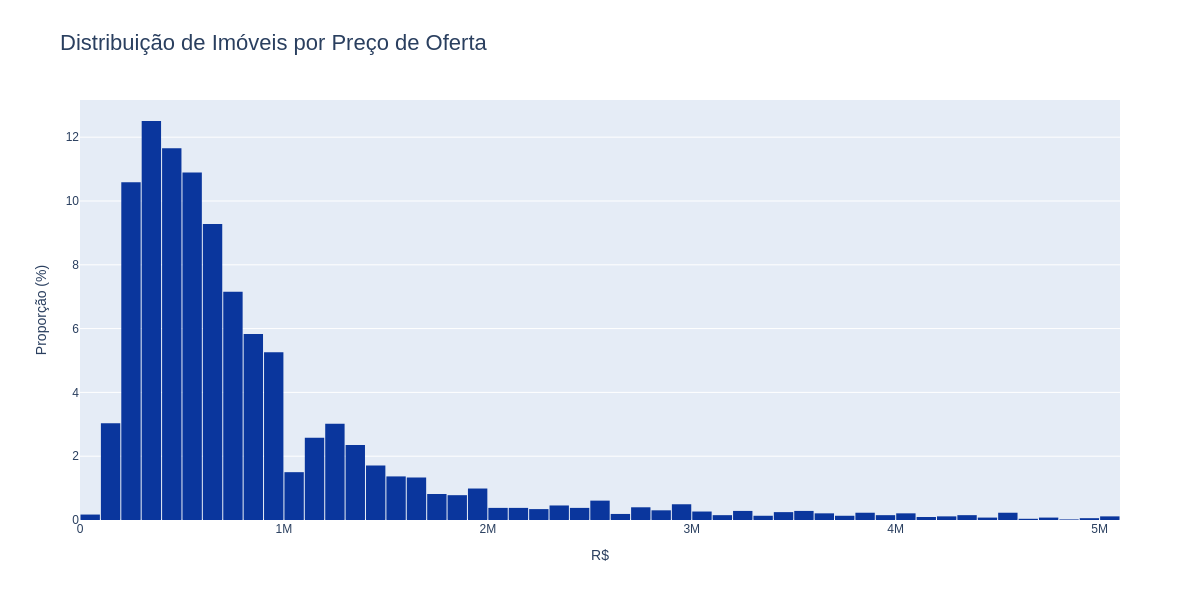

In [151]:
plot_hist(df[df['preco']<=5_000_000], 'preco', 'Distribuição de Imóveis por Preço de Oferta', 'R$', 'Proporção (%)')

Os imóveis ofertados se concentram numa faixa inferior aos R$ 1.000.000,00.

### Análises multivariadas

Agora é o momento de analisar a relação do preço com as variáveis. 

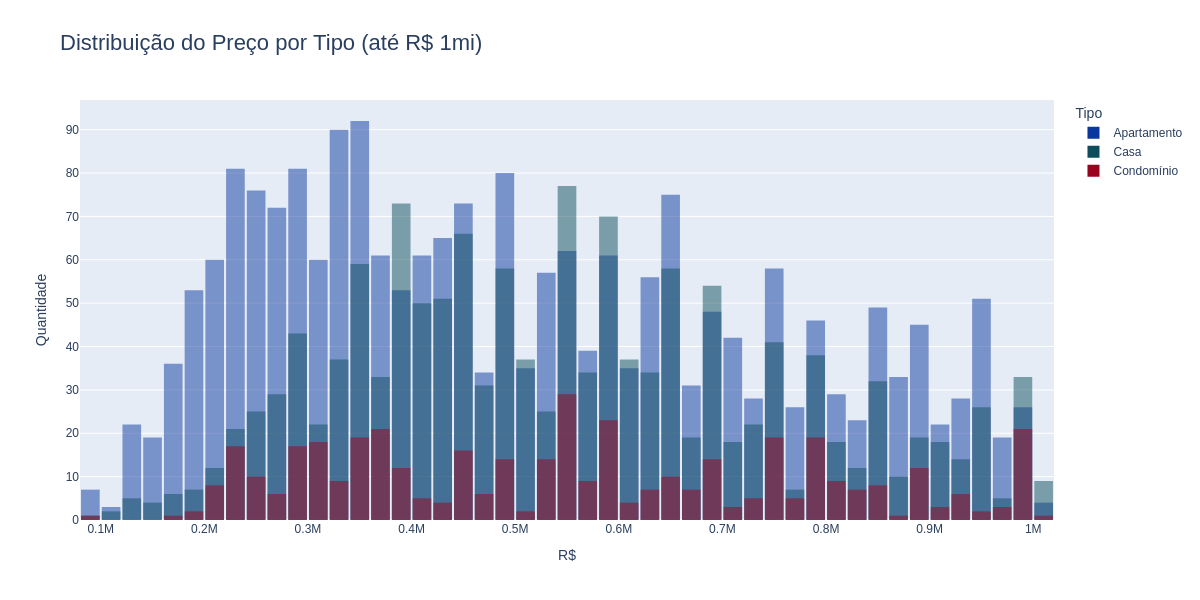

In [153]:
fig = px.histogram(
    df[df['preco']<=1_000_000], 
    x = 'preco', 
    color='tipo', 
    barmode='overlay', 
    color_discrete_sequence=['#0a369d','#0f4c5c', '#9a031e'],
    title='Distribuição do Preço por Tipo (até R$ 1mi)'
)

fig.update_layout(
    bargap=0.1,
    xaxis_title='R$',
    yaxis_title='Quantidade',
    legend_title='Tipo',
    width=1200,
    height=600,
    title_font={'size': 22}
)

fig.show(renderer='png')

Apartamentos são os imóveis mais acessíveis, é possível encontrar eles em toda faixa de preço mas são predominantes em valores menores que R$ 500.000,00. Casas dentro e fora de condomínios também aparecem em praticamente todas as faixar de preço mas aparecem mais a partir dos R$ 300.000,00. 

Agora vamos avaliar o preço dos imóveis de acordo com sua localização a partir de dois pontos:
- Valor médio;
- Valor médio do m² construído.

Vou também usar um critério de bairros com pelo menos 20 imóveis ou mais em oferta.

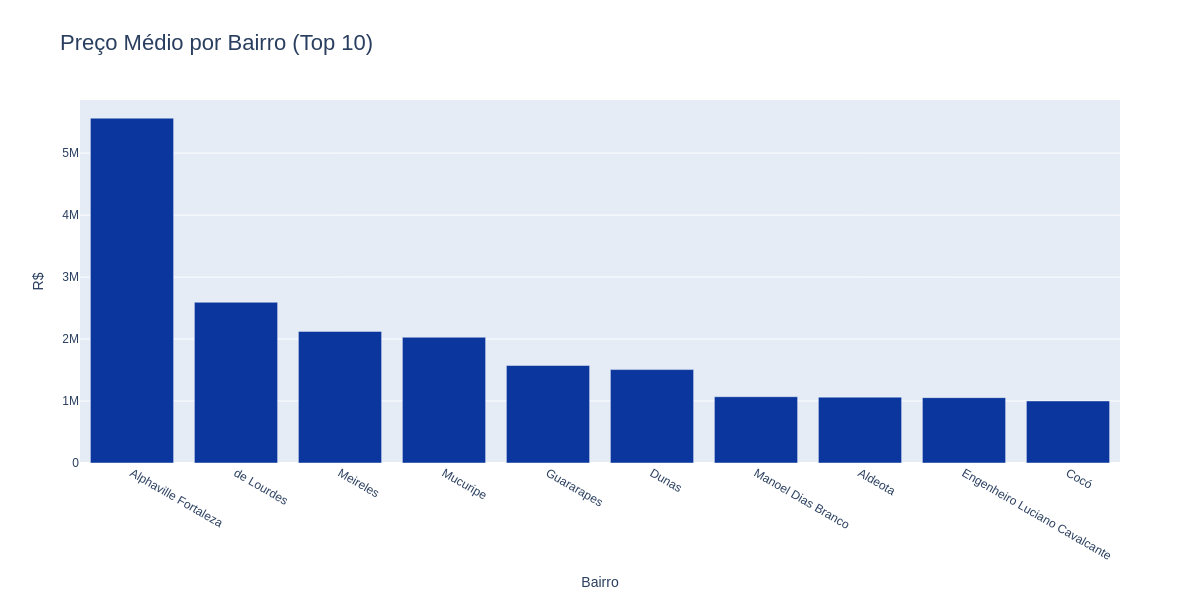

In [154]:
bairros = duckdb.sql(
    """
    SELECT
        localizacao
        , AVG(preco)::DECIMAL(18, 2) AS preco_medio
        , COUNT(localizacao) AS qt_imoveis
    FROM df
    GROUP BY localizacao
    HAVING qt_imoveis > 20
    ORDER BY 2 DESC
    LIMIT 10
    """
)
plot_bars(bairros, 'localizacao', 'preco_medio', 'Preço Médio por Bairro (Top 10)', 'Bairro', 'R$')

Os bairros com maior média de preço estão localizados próximos à orla e ao centro da cidade (especialmente nas SER 2 e 7). O Alphaville Fortaleza é localizado dentro do bairro da Sabiaguaba, e próximo também a outra área valoriza que são bairros próximos à cidade de Eusébio (como o Coaçu) que é uma cidade parte da Região Metropilitana de Fortaleza (RMF) que passa por um alto crescimento e expansão de infraestrutura e mercado imobliário. 

Vamos visualizar o top 10 em o Alphaville Fortaleza.  

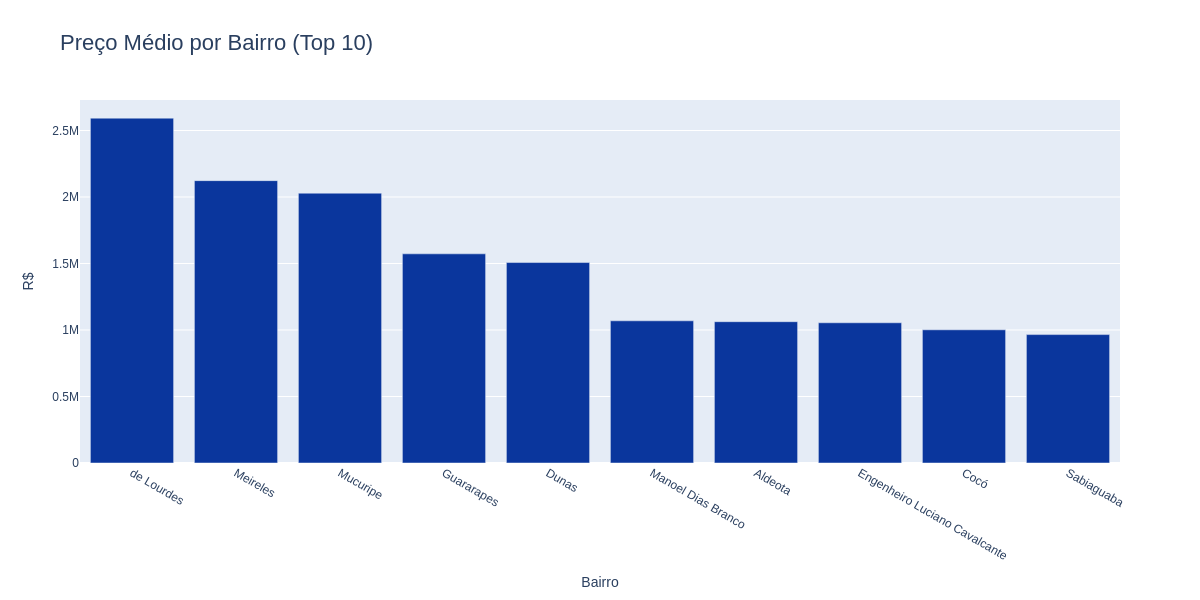

In [155]:
bairros = duckdb.sql(
    """
    SELECT
        localizacao
        , AVG(preco)::DECIMAL(18, 2) AS preco_medio
        , COUNT(localizacao) AS qt_imoveis
    FROM df
    WHERE localizacao <> 'Alphaville Fortaleza'
    GROUP BY localizacao
    HAVING qt_imoveis > 20
    ORDER BY 2 DESC
    LIMIT 10
    """
)
plot_bars(bairros, 'localizacao', 'preco_medio', 'Preço Médio por Bairro (Top 10)', 'Bairro', 'R$')

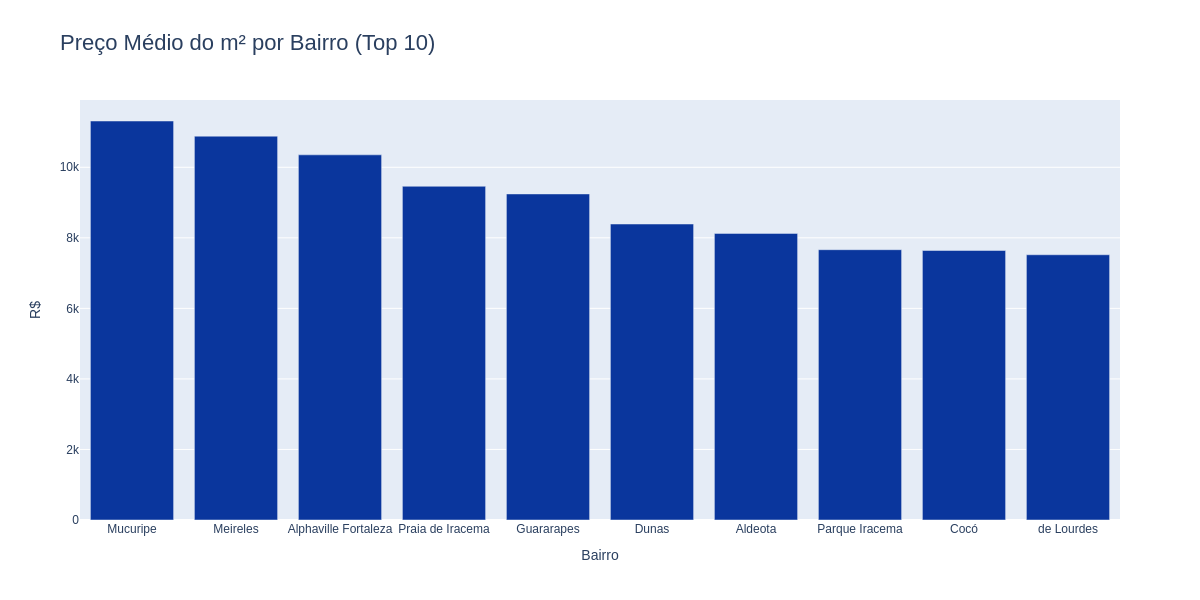

In [157]:
bairros = duckdb.sql(
    """
    WITH cte AS (
        SELECT
            localizacao
            , preco/area AS preco_m2
        FROM df
        GROUP BY localizacao, area, preco
    )
    SELECT 
        localizacao
        , AVG(preco_m2) AS avg_preco_m2
        , COUNT(localizacao) AS qt_imoveis 
    FROM cte
    GROUP BY localizacao
    HAVING qt_imoveis > 20
    ORDER BY 2 DESC
    LIMIT 10
    """
)
plot_bars(bairros, 'localizacao', 'avg_preco_m2', 'Preço Médio do m² por Bairro (Top 10)', 'Bairro', 'R$')

Mucuripe, Meireles e Guararapes se demonstram bairros com alto potencial de investimento por seu alto valor de metro quadrado, mas isso exige altos aportes, assim como o bairro de Lourdes. O Parque Iracema também possui um alto valor no preço do metro quadrado, ele está localizado na SER 6, e é próximo de bairros como Messejana, Cambeba e Cajazeiras que possuem um grande extensão territorial. 

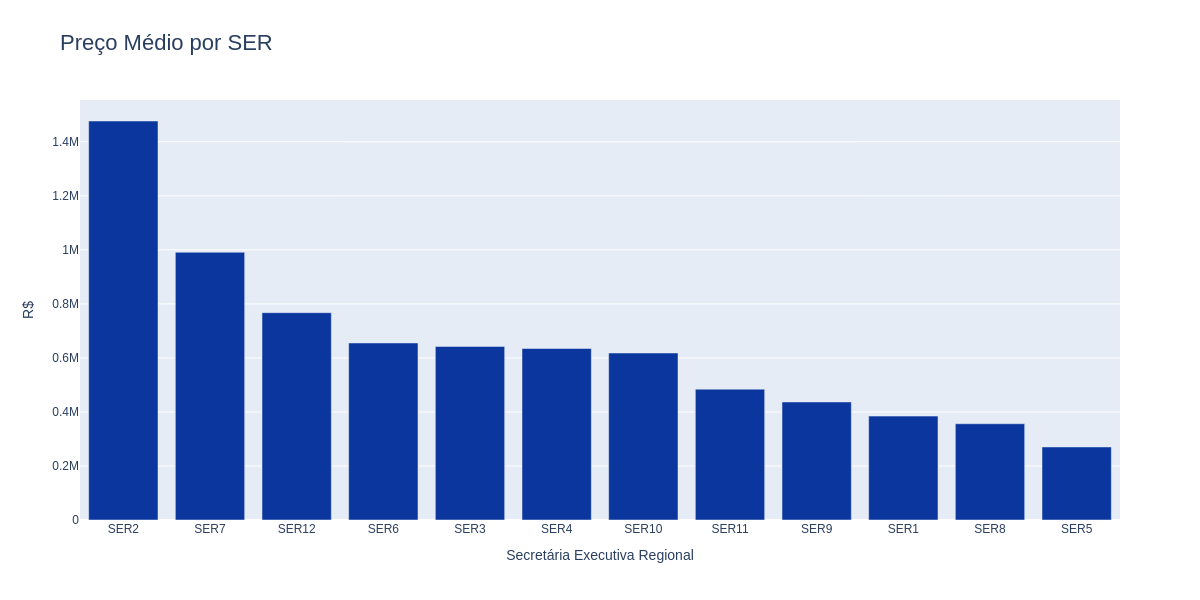

In [160]:
ser = duckdb.sql(
    """
    SELECT
        ser
        , AVG(preco)::DECIMAL(18, 2) AS preco_medio
        , COUNT(ser) AS qt_imoveis
    FROM df
    WHERE ser <> 'Outros'
    GROUP BY ser
    ORDER BY 2 DESC
    """
)
plot_bars(ser, 'ser', 'preco_medio', 'Preço Médio por SER', 'Secretária Executiva Regional', 'R$')

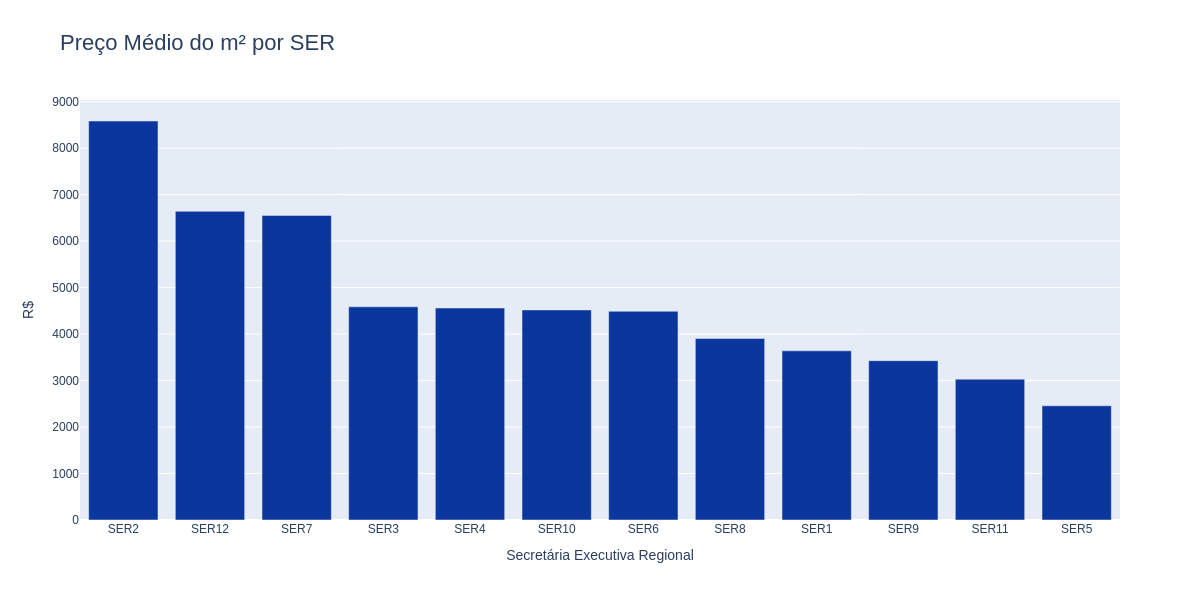

In [161]:
bairros = duckdb.sql(
    """
    WITH cte AS (
        SELECT
            ser
            , preco/area AS preco_m2
        FROM df
        GROUP BY ser, area, preco
    )
    SELECT 
        ser
        , AVG(preco_m2) AS avg_preco_m2
        , COUNT(ser) AS qt_imoveis 
    FROM cte
    WHERE ser <> 'Outros'
    GROUP BY ser
    ORDER BY 2 DESC
    """
)
plot_bars(bairros, 'ser', 'avg_preco_m2', 'Preço Médio do m² por SER', 'Secretária Executiva Regional', 'R$')

Os imóveis em SERs mais próximas do centro (SER 12) são mais os mais valorizados. 

### Testes de hipóteses

#### Proximidade do Centro

- $H_0:$ A proximidade do Centro não tem efeito relevante sobre o preço.
- $H_1:$ A proximidade do centro tem efeito relevante sobre o preço.

In [162]:
from scipy.stats import mannwhitneyu

grupo_a = df[df['prox_centro']=='Sim']['preco']
grupo_b = df[df['prox_centro']=='Não']['preco']

_, p_value = mannwhitneyu(grupo_a, grupo_b, alternative='greater')
alpha = 0.05

if p_value < alpha:
    print("Rejeitamos a hipótese nula.")
    print("Há evidências estatísticas o suficiente de que o preço dos imóveis é afetado pela próximidade ao Centro.")
else:
    print("Não rejeitamos a hipótese nula.")
    print("Não há evidências estatísticas o suficiente de que o preço dos imóveis é afetado pela próximidade ao Centro.")

Rejeitamos a hipótese nula.
Há evidências estatísticas o suficiente de que o preço dos imóveis é afetado pela próximidade ao Centro.


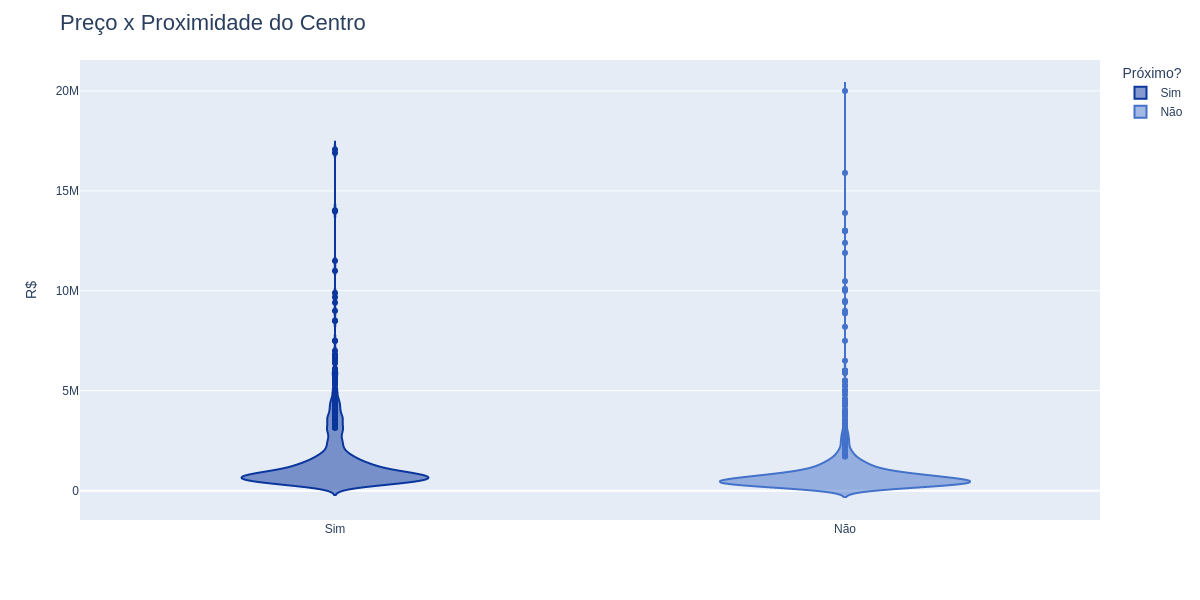

In [163]:
fig = px.violin(
    df, 
    x = 'prox_centro', 
    y='preco', 
    color='prox_centro',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Preço x Proximidade do Centro',
    title_font={'size': 22},
    xaxis_title='',
    yaxis_title='R$',
    legend_title='Próximo?',
    width=1200,
    height=600
)

fig.show(renderer='png')

#### Proximidade do Orla

- $H_0:$ A proximidade do Orla não tem efeito relevante sobre o preço.
- $H_1:$ A proximidade do Orla tem efeito relevante sobre o preço.

In [164]:
from scipy.stats import mannwhitneyu

grupo_a = df[df['prox_orla']=='Sim']['preco']
grupo_b = df[df['prox_orla']=='Não']['preco']

_, p_value = mannwhitneyu(grupo_a, grupo_b, alternative='greater')
alpha = 0.05

if p_value < alpha:
    print("Rejeitamos a hipótese nula.")
    print("Há evidências estatísticas o suficiente de que o preço dos imóveis é afetado pela próximidade à Orla.")
else:
    print("Não rejeitamos a hipótese nula.")
    print("Não há evidências estatísticas o suficiente de que o preço dos imóveis é afetado pela próximidade à Orla.")

Rejeitamos a hipótese nula.
Há evidências estatísticas o suficiente de que o preço dos imóveis é afetado pela próximidade à Orla.


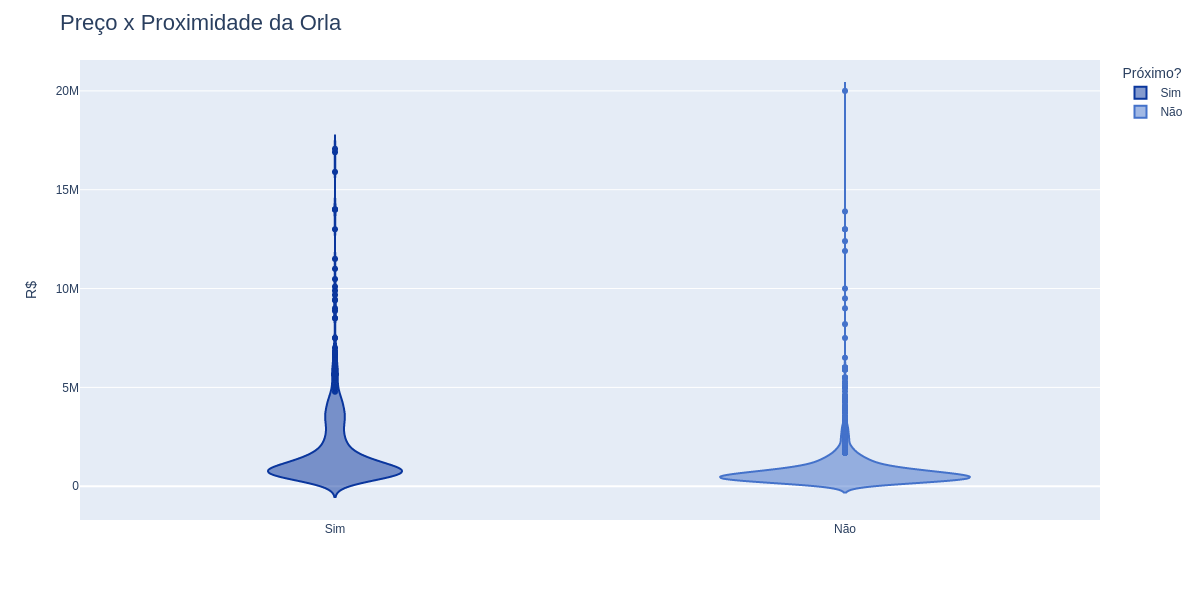

In [165]:
fig = px.violin(
    df, 
    x = 'prox_orla', 
    y='preco', 
    color='prox_orla',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Preço x Proximidade da Orla',
    title_font={'size': 22},
    xaxis_title='',
    yaxis_title='R$',
    legend_title='Próximo?',
    width=1200,
    height=600
)

fig.show(renderer='png')

### Matriz de Correlação

In [166]:
data = df.drop(columns=['quartos_ord', 'banheiros_ord', 'vagas_ord'], axis=1).copy()
for col in ['prox_centro', 'prox_orla']:
    data[col] = data[col].map({'Sim': 1, 'Não': 0})
corr = data.corr(numeric_only=True).round(4)

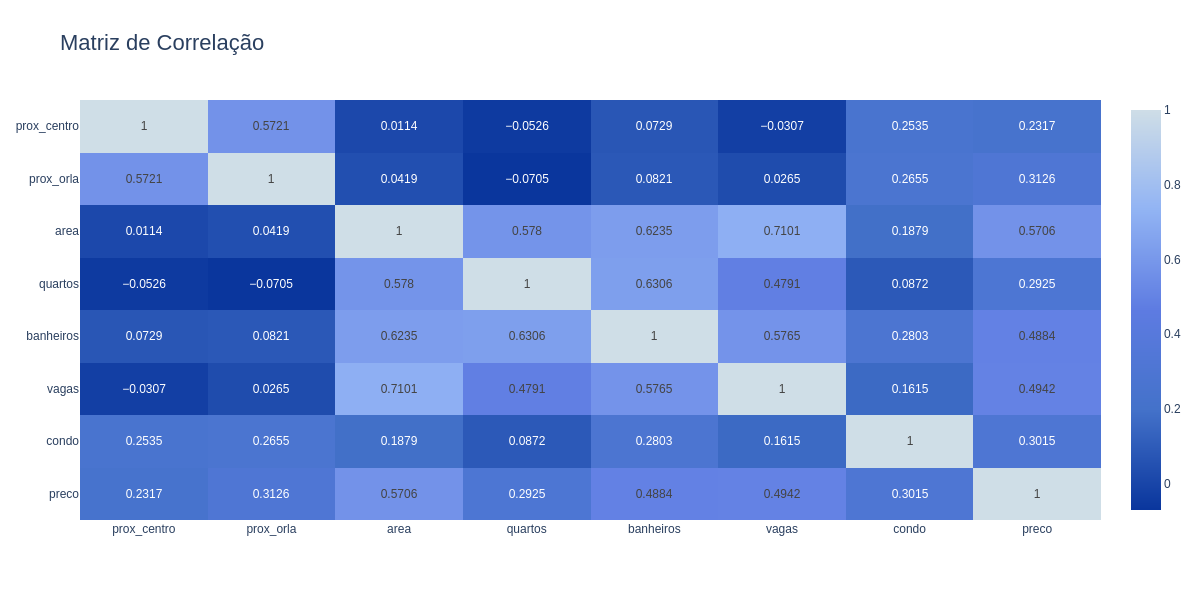

In [167]:
fig = px.imshow(
    corr, 
    text_auto=True, 
    aspect='auto', 
    color_continuous_scale=palette, 
    title='Matriz de Correlação',
    width=1200,
    height=600 
)
fig.update_layout(title_font={'size': 22})
fig.show(renderer='png')

A variáveis que tenho maior efeito sobre o preço dos imóveis são a área, banheiros e vagas, o número de quartos tem uma correlação menor do que eu particularmente esperava. A proximidade da orla tem uma correlação com o preço do que do centro. 

### Conclusões

- O tipo de imóvel mais amplamente ofertado são apartamentos, também são os imóveis mais acessíveis. Casas dentro e foram de condomínios começam a aparecer em ofertas a partir de R$ 300.000,00. 
- Os imóveis disponíveis se concetram abaixo dos 100m² de área. 
- Os bairros das Secretárias Executiva Regionais (SER) 2 e 7 são os mais valorizados e com maior número de imóveis ofertados. 
- Mucuripe, Meireles e Guararapes se demonstram bairros com alto potencial de investimento por seu alto valor de metro quadrado, mas isso exige altos aportes, assim como o bairro de Lourdes. O Parque Iracema também possui um alto valor no preço do metro quadrado, ele está localizado na SER 6, e é próximo de bairros como Messejana, Cambeba e Cajazeiras que possuem um grande extensão territorial.
- As variáveis que tem maior influência no preço de imóvel são o número de banheiros, vagas de garagem e áreea. O número de quartos tem uma influência menor, sendo alguns padrões de oferta comuns imóveis com 3 quartos e 2 a 3 banheiros.

In [ ]:
# Dados limpos
data.to_csv("../data/processed/clean_data.csv", index=False)